In [1]:
# Make sure Runtime > Change runtime type is set to GPU

# Setup
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.text.all import *

     |████████████████████████████████| 720 kB 1.4 MB/s 
     |████████████████████████████████| 186 kB 15.2 MB/s 
     |████████████████████████████████| 46 kB 1.3 MB/s 
     |████████████████████████████████| 1.2 MB 35.6 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |████████████████████████████████| 51 kB 289 kB/s 
Mounted at /content/gdrive


In [2]:
# Find the news category on the drive
import os
os.listdir( "gdrive/MyDrive/Dustin Garvey Shared/EAI6010 - Applications of AI/2021-07-23 Development" )

['Program Review.xlsx',
 'Dustin Garvey - EAI6010 - Applications of AI - Outline Dev.gdoc',
 'Module 6 - Model APIs & AutoML - Media Content.gdoc',
 'Module 1 - Introduction to Computer Vision - Media Content.gdoc',
 'Module 2 - Computer Vision with Transfer Learning - Media Content.gdoc',
 'Module 4 - Survey of Other Applications and Lifecycle Considerations - Media Content.gdoc',
 'Module 3 - Text Classification with Transfer Learning - Media Content.gdoc',
 'UCMerced_LandUse.zip',
 'NewsCategory_v2.zip',
 '2021-09-13 - GCP Run Tinkering.zip',
 'module_3_fine_tuned_language_model',
 'news_category_classifier',
 'Module 5 - AI End-to-End - Media Content.gdoc']

In [3]:
# Unzip the data set
!unzip "gdrive/MyDrive/Dustin Garvey Shared/EAI6010 - Applications of AI/2021-07-23 Development/NewsCategory_v2.zip" 
print( "\n\n" )
os.listdir( )

Archive:  gdrive/MyDrive/Dustin Garvey Shared/EAI6010 - Applications of AI/2021-07-23 Development/NewsCategory_v2.zip
   creating: NewsCategory_v2/
  inflating: NewsCategory_v2/source.txt  
  inflating: NewsCategory_v2/News_Category_Dataset_v2.json  
  inflating: __MACOSX/NewsCategory_v2/._News_Category_Dataset_v2.json  





['.config', 'NewsCategory_v2', 'gdrive', '__MACOSX', 'sample_data']

In [4]:
# Let's see what's in the extracted data
print( f"root directory:\n{os.listdir( 'NewsCategory_v2' )}" )

# Simple enough -- a single JSON document, let's load it and see what we have.

root directory:
['source.txt', 'News_Category_Dataset_v2.json']


In [5]:
# The JSON isn't a valid format -- load it by line first
with open( os.path.join( "NewsCategory_v2", "News_Category_Dataset_v2.json" ), "r" ) as f:
  record_lines = f.readlines( )

# ...then parse each line
import json
record_jsons = list( )
for record_line in record_lines:
  record_json = json.loads( record_line )
  record_jsons.append( record_json )

# Show the first record
print( f"first record:\n{record_jsons[ 2 ]}" )

# We have the article's headline, short description, & category. This format
# isn't very handy to use with the fast.ai libraries though -- we need to 
# do some additional formatting.

first record:
{'category': 'ENTERTAINMENT', 'headline': 'Hugh Grant Marries For The First Time At Age 57', 'authors': 'Ron Dicker', 'link': 'https://www.huffingtonpost.com/entry/hugh-grant-marries_us_5b09212ce4b0568a880b9a8c', 'short_description': 'The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.', 'date': '2018-05-26'}


In [6]:
# Let's filter everything to a subset of the classes because language models
# are really really slow to train

# Collect the classes
categories = set( )
for record_json in record_jsons:
  categories.add( record_json[ 'category' ] )
print( f"num. categories: {len( categories )}\n\ncategories:\n{categories}" )

# Keep only the first categories -- you can tinker with this step to train the 
# model on fewer-more categories
category_subset = list( categories )[ 0 : 10 ]
print( f"\ncategory subset:\n{category_subset}" )

num. categories: 41

categories:
{'WOMEN', 'GREEN', 'CULTURE & ARTS', 'WORLD NEWS', 'BUSINESS', 'ENVIRONMENT', 'COLLEGE', 'IMPACT', 'STYLE', 'FOOD & DRINK', 'PARENTING', 'LATINO VOICES', 'FIFTY', 'RELIGION', 'HEALTHY LIVING', 'WEIRD NEWS', 'STYLE & BEAUTY', 'MONEY', 'ARTS', 'ENTERTAINMENT', 'MEDIA', 'SCIENCE', 'COMEDY', 'ARTS & CULTURE', 'GOOD NEWS', 'TRAVEL', 'DIVORCE', 'POLITICS', 'PARENTS', 'TASTE', 'HOME & LIVING', 'WEDDINGS', 'WORLDPOST', 'CRIME', 'TECH', 'THE WORLDPOST', 'SPORTS', 'WELLNESS', 'BLACK VOICES', 'EDUCATION', 'QUEER VOICES'}

category subset:
['WOMEN', 'GREEN', 'CULTURE & ARTS', 'WORLD NEWS', 'BUSINESS', 'ENVIRONMENT', 'COLLEGE', 'IMPACT', 'STYLE', 'FOOD & DRINK']


In [7]:
# Let's follow the convention of a folder per class with single files per 
# record

# Reset the root directory if we need to -- we check and delete so this code is repeatable
root_dir_name = "news_by_category"
print( f"setting up '{root_dir_name}'" )
if os.path.exists( root_dir_name ):
  shutil.rmtree( root_dir_name )
os.mkdir( root_dir_name )

# Initialize the counts for each of the subset
category_to_count = dict( )
for category in category_subset:
  category_to_count[ category ] = 0

# Create a file for each record and put it in a subfolder named for the category
count = 0
total_words = 0 # we need to set a sequence length for the language model, so we should capture the typical lengths of the documents
for record in record_jsons:

  # Skip this record if its not one of the categories we are interested in
  category = record[ "category" ]
  if category not in category_subset:
    continue

  # Update the processed count and show the progress if we should
  count = count + 1
  if ( count % 10000 ) == 0:
    print( f"creating file for record {int(count/1000)}k" )

  # Setup the directory if it doesn't exist
  dir_path = os.path.join( root_dir_name, category )
  if not os.path.exists( dir_path ):
    os.mkdir( dir_path )

  # Build the document text and save the word length
  document_text = f"{record[ 'headline' ]} \n {record[ 'short_description' ]} \n " # document content is the headline + short description
  total_words = total_words + len( document_text.split( " " ) )

  # Save the document text to file
  category_count = category_to_count[ category ] + 1
  category_to_count[ category ] = category_count
  filename = f"{category}-{category_count}.txt"
  file_path = os.path.join( dir_path, filename )
  with open( file_path, "w" ) as f:
    f.write( document_text )

# Verify the directories
print( f"\nworking directory:\n{os.listdir( )}" )
print( f"\ndata directory:\n{os.listdir( root_dir_name )}" )
category_dir_path = os.path.join( root_dir_name, category_subset[ 0 ] )
print( f"\n'{category_dir_path}'':\n{os.listdir( os.path.join( root_dir_name, category_subset[ 0 ] ) )}" )
category_dir_path = os.path.join( root_dir_name, category_subset[ 1 ] )
print( f"\n'{category_dir_path}'':\n{os.listdir( os.path.join( root_dir_name, category_subset[ 1 ] ) )}" )

# Verify a document
with open( os.path.join( category_dir_path, f"{category_subset[ 1 ]}-1.txt" ), 'r' ) as f:
  document_content = f.readlines( )
  print( f"\ndocument content:\n{document_content}" )

# Calculate the average document length so we can intelligently set the sequence length (predict the next word give the input sequence)
avg_document_words = round( total_words / count )
print( f"\naverage number of words in a document = {avg_document_words}")

setting up 'news_by_category'
creating file for record 10k
creating file for record 20k

working directory:
['.config', 'NewsCategory_v2', 'gdrive', 'news_by_category', '__MACOSX', 'sample_data']

data directory:
['FOOD & DRINK', 'IMPACT', 'COLLEGE', 'ENVIRONMENT', 'WORLD NEWS', 'GREEN', 'CULTURE & ARTS', 'WOMEN', 'STYLE', 'BUSINESS']

'news_by_category/WOMEN'':
['WOMEN-1834.txt', 'WOMEN-2432.txt', 'WOMEN-1538.txt', 'WOMEN-3206.txt', 'WOMEN-3054.txt', 'WOMEN-2349.txt', 'WOMEN-2993.txt', 'WOMEN-2241.txt', 'WOMEN-709.txt', 'WOMEN-299.txt', 'WOMEN-2898.txt', 'WOMEN-112.txt', 'WOMEN-3160.txt', 'WOMEN-916.txt', 'WOMEN-367.txt', 'WOMEN-732.txt', 'WOMEN-386.txt', 'WOMEN-1393.txt', 'WOMEN-2523.txt', 'WOMEN-535.txt', 'WOMEN-769.txt', 'WOMEN-800.txt', 'WOMEN-2797.txt', 'WOMEN-2703.txt', 'WOMEN-2185.txt', 'WOMEN-3212.txt', 'WOMEN-3092.txt', 'WOMEN-1898.txt', 'WOMEN-2662.txt', 'WOMEN-2323.txt', 'WOMEN-2589.txt', 'WOMEN-670.txt', 'WOMEN-1559.txt', 'WOMEN-2359.txt', 'WOMEN-575.txt', 'WOMEN-811.txt',

In [8]:
# Now that we have data in a format that is typical, let's get it ready to fine 
# tune a language model

# First the data block to tell how normalize things -- there is caching
# happening in the data block -- if you change the directory content at all
# after this object is created, do a "Factory reset runtime" (Runtime menu) to
# fully reset the environment
language_model_block = DataBlock( # https://docs.fast.ai/data.block.html
  blocks = TextBlock.from_folder( root_dir_name, is_lm = True ), # read the data from folder and indicate the data is to be used for a language model
  get_items = get_text_files, # each item is a text file
  splitter = RandomSplitter( seed = 42 ) # randomly split the samples 
)

# And now data loaders
language_model_loaders = language_model_block.dataloaders( root_dir_name, bs = 128, seq_len = 20 ) # 128 batch size & sequence length roughly 2/3 of the average document length

# Show a batch to confirm
language_model_loaders.show_batch( max_n = 3 )

# The left is the input and the right is the target. You can see we are 
# are using seq_len words to predict seq_len words that have been shifted 
# forward by a single word.

,text,text_
0,xxbos xxmaj xxunk xxmaj unite xxmaj to xxmaj save ' world 's xxmaj saddest xxmaj bear ' xxmaj from xxmaj,xxmaj xxunk xxmaj unite xxmaj to xxmaj save ' world 's xxmaj saddest xxmaj bear ' xxmaj from xxmaj argentine
1,official day where everyone can choose to shift their minds towards a more empowered state . xxbos xxmaj blame the,day where everyone can choose to shift their minds towards a more empowered state . xxbos xxmaj blame the xxmaj
2,"xxunk was tempted , but then refused to have her photo taken for xxmaj xxunk xxmaj xxunk 's "" xxunk","was tempted , but then refused to have her photo taken for xxmaj xxunk xxmaj xxunk 's "" xxunk 's"


In [9]:
# There is less to choose from here for pretrained models, let's use AWD_LSTM 
# packaged with fast.ai

# Let's build a learner for the language model
learner = language_model_learner(
    language_model_loaders, # what data goes in
    AWD_LSTM, # what pretrained model to use -- here we have AWD_LSTM
    drop_mult = 0.3, #  randomly drop out this fraction of values 
    metrics = [ accuracy, Perplexity( ) ] # perplexity is the cross entropy for language models - https://docs.fast.ai/metrics.html#Perplexity
).to_fp16( ) # optimize performance - https://docs.fast.ai/callback.fp16.html

In [ ]:
# We can't find the best learning rate for language models -- doesn't look like 
# fast.ai supports this functionality and it would take forever 

# Let's just do a fine tuning epoch to see where we are -- remember a single 
# fine tuning epoch involves one epoch to tune the output layer and one epoch
# to tune the entire network
learner.fine_tune( 1 )

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.854062,3.726190,0.393168,41.520596,06:53


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.482889,3.464007,0.421051,31.944719,07:42


In [ ]:
# We need to do a bit more fine tuning since our accuracy is roughly 40% --
# we will just do one iteration because it is so slow, but this should be 
# extended to get a better model
for i in range( 1 ):
  print( f"\n\nfine tuning iteration #{i+1}" )
  learner.fine_tune( 1 )



fine tuning iteration #1


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.587118,3.585776,0.383579,36.081348,06:41


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.464087,3.537136,0.388828,34.368351,07:36


In [10]:
# To finish up the langage model fine tuning we save the encoder to disk
language_model_path = os.path.join( "gdrive/MyDrive/Dustin Garvey Shared/EAI6010 - Applications of AI/2021-07-23 Development/module_3_fine_tuned_language_model" )
with open( language_model_path, "wb" ) as f:
  learner.save_encoder( f )

In [11]:
# To start on the classifier we need to create new data block and loaders

# Start with a new data block
vocabulary = language_model_loaders.vocab # don't create a new vocabulary, use the same that was created for the language model
classifier_block = DataBlock( 
    blocks = ( TextBlock.from_folder( root_dir_name, vocab = vocabulary ), CategoryBlock ), # x & y
    get_y = parent_label, # y values are the names of the folder that contain the documents
    get_items = get_text_files,
    splitter = RandomSplitter( seed = 42 ) # randomly split the samples 
)

# And the data loaders
classifier_loaders = classifier_block.dataloaders( root_dir_name, bs = 128, seq_len = 20 ) # 128 batch size & sequence length roughly 2/3 of the average document length

# Show a batch to confirm
classifier_loaders.show_batch( max_n = 3 )

# This time the x is the text and the y is the category


,text,category
0,"xxbos xxmaj columbia xxmaj students xxmaj reveal xxmaj university xxmaj missteps xxmaj in xxmaj sexual xxmaj assault xxmaj investigations \n▁ a huffpost examination of xxmaj zachary 's case , as well as those by two others students -- based on hundreds of pages of xxmaj columbia 's xxunk reports and emails xxunk between university officials and students -- shows that xxmaj emma xxmaj sulkowicz 's case is not an isolated incident . xxmaj these documents show that both before and after the investigation of xxmaj sulkowicz 's alleged sexual assault , xxmaj columbia has taken missteps in handling other cases , failing to adhere to federal guidance and standards . \n\n xxmaj title xxup ix , the federal law that xxunk gender equality in education , advises sexual assault cases be fully resolved within 60 days of the initial reporting . xxmaj columbia 's policy goes further , stating that",COLLEGE
1,"xxbos xxmaj romney 's xxmaj other xxmaj credibility xxmaj problem : xxmaj glenn xxmaj hubbard \n▁ xxmaj there is a scandal in xxmaj mitt xxmaj romney 's campaign -- namely xxmaj glenn xxmaj hubbard , xxmaj romney 's chief economic advisor , who was chairman of the xxmaj council of xxmaj economic xxmaj advisors under xxmaj george xxup w. xxmaj bush , and is now xxmaj dean of xxmaj columbia xxmaj business xxmaj school . xxmaj first , xxmaj hubbard has an xxunk track record in economic policy , including the very issues that xxmaj romney has made the xxunk of his presidential campaign . xxmaj second , like xxmaj romney , xxmaj hubbard refuses to disclose critical information about his income , conflicts of interest , and paid advocacy activities . xxmaj third , both in public statements and in my personal experience , xxmaj hubbard has been evasive",BUSINESS
2,"xxbos xxmaj how to xxmaj read the xxmaj week 's xxmaj economic and xxmaj market xxmaj signals \n▁ xxmaj expect next week 's policy meetings to signal that central bank stand ready to step in , once again , to maintain the disconnect between xxunk equity markets and sluggish economic conditions -- not as an end in itself but , given xxmaj congressional dysfunction , as virtually the only way today to support economic activity ( and it is rather imperfect as the expected benefits come with growing costs and risks ) . xxmaj look for the xxmaj federal xxmaj reserve to alter the thrust of its policy narrative . xxmaj rather than advance its prior emphasis on xxunk its monthly $ 85 billion purchases of market securities , it will seek to reassure markets by xxunk its willingness to do more if needed . xxmaj across the xxmaj atlantic",BUSINESS


In [13]:
# Now its time to create the classification model

# We start by creating a new learner starting with the same model as the 
# language model
learner = text_classifier_learner(
    classifier_loaders, # what data goes in -- this time its the classifier_loaders
    AWD_LSTM, # what pretrained model to use -- here we have AWD_LSTM
    drop_mult = 0.3, #  randomly drop out this fraction of values 
    metrics = accuracy # classification accuracy is what we'll use to evaluate performance
).to_fp16( ) # optimize performance - https://docs.fast.ai/callback.fp16.html

# Now, let's load the language model that was fined tuned for this set and 
# overwrite the encoding portion of the new learner
with open( language_model_path, "rb" ) as f:
  learner = learner.load_encoder( f )


In [14]:
# Let's find our feet by doing a single fine tuning epoch to see where we are
learner.fine_tune( 1 )

epoch,train_loss,valid_loss,accuracy,time
0,1.280967,0.956686,0.690324,00:57


epoch,train_loss,valid_loss,accuracy,time
0,0.959866,0.812947,0.736682,02:08


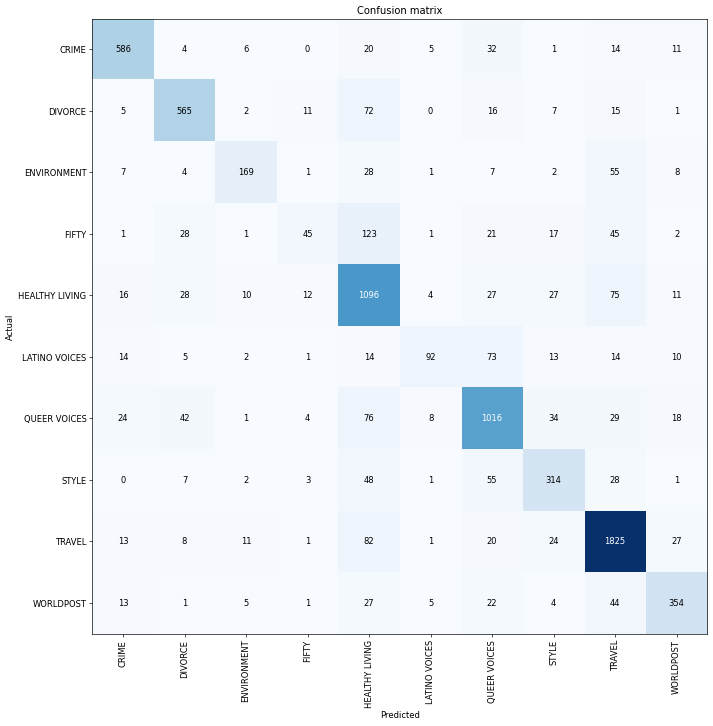

In [ ]:
#  What does the confusion matrix look like after a single epoch?
interpretation = ClassificationInterpretation.from_learner( learner )
interpretation.plot_confusion_matrix( figsize = ( 12, 12 ), dpi = 60 )

# Not to bad -- let's push forward and tune a bit more

In [ ]:
# Lets do a couple of fine tuning epochs 
for i in range( 1 ):
  print( f"\n\nfine tuning iteration #{i+1}" )
  learner.fine_tune( 1, base_lr = 0.02 )



fine tuning iteration #1


epoch,train_loss,valid_loss,accuracy,time
0,0.814919,0.678429,0.786574,01:27


epoch,train_loss,valid_loss,accuracy,time
0,0.617923,0.505201,0.836414,03:28


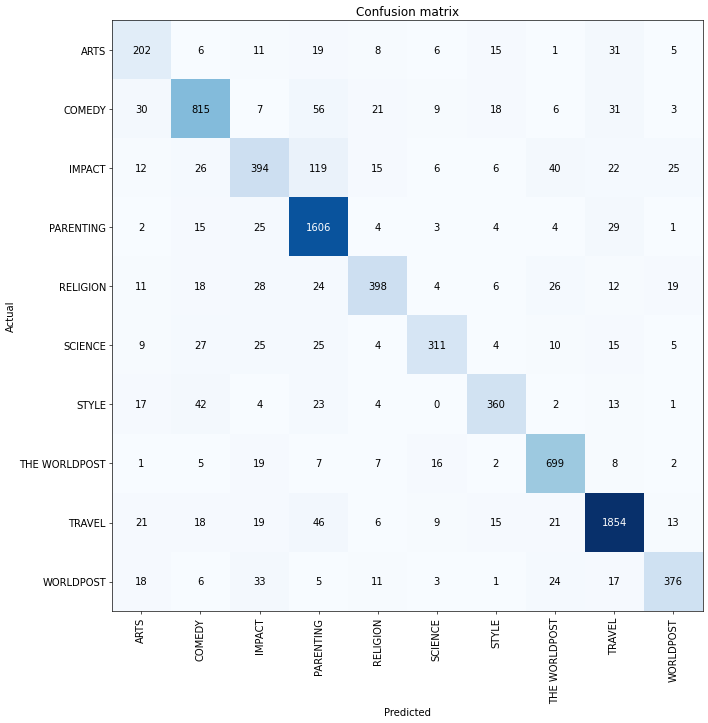

In [ ]:
# And finally the confusion matrix
interpretation = ClassificationInterpretation.from_learner( learner )
interpretation.plot_confusion_matrix( figsize = ( 12, 12 ), dpi = 60 )

In [15]:
# Let's finish up by saving the classifier to disk 
classifier_path = os.path.join( "gdrive/MyDrive/Dustin Garvey Shared/EAI6010 - Applications of AI/2021-07-23 Development/news_category_classifier" )
learner.export( classifier_path )

In [16]:
# Let's load the model and make a prediction
learner = []
learner = load_learner( classifier_path )
content = "Priceless Picasso painting on exhibit in a supermarket near the beer aisle \n The goal is to make art more accessible for all."
prediction, prediction_possibility, prediction_possibilities = learner.predict( content )
print( f"prediction = {prediction}\n\n" )

prediction = CULTURE & ARTS


